In [38]:
from matplotlib import pyplot as plt
import numpy as np

In [39]:
import math

def evaluate_traj_length(traj):
    path_length = 0
    for idx in range(1, traj.size // 2):
        path_length += math.pow(
            math.pow(traj[idx , 0] - traj[idx - 1 , 0], 2) + math.pow(traj[idx, 1] - traj[idx - 1, 1], 2),
            0.5
        )
    return path_length

def evaluate_env_free_space(env):
    return 100 * np.count_nonzero((env.arena.occ_grid == 0) == True) / env.arena.occ_grid.size

In [40]:
from environment import RBF2dGymEnv
from controller import RRTController
from kernel import RRTKernelNormal, RBF2dEnvKernelNormal

def evaluate(model_params, plot_sol=False):
    env = RBF2dGymEnv(
        use_lidar=False,
        N_points=int(model_params[0]),
        threshold=model_params[1],
        rbf_gamma=model_params[2],
        obs_low=-0.7,
        obs_high=0.7,
        grid_res=150,
        grid_bd=1.2
    )
    controller = RRTController()
    controller_kernel = RRTKernelNormal([-1, -1], [1, 1])
    env_kernel = RBF2dEnvKernelNormal()
    env_kernel.sample_prior()
    controller_kernel.sample_prior()
    env.reset(env_kernel.value)
    traj = controller.get_trajectory(env, controller_kernel)
    if plot_sol:
        plt.imshow(env.arena.occ_grid, origin='lower', extent=[-1.2, 1.2, -1.2, 1.2], cmap='gray_r', vmin=0, vmax=2)
        plt.plot(traj[:, 0], traj[:, 1])
        plt.show()
    return evaluate_traj_length(traj), evaluate_env_free_space(env), 5

In [41]:
from ribs.archives import GridArchive

archive = GridArchive(
    [100, 10],
    [(0.0, 100.0), (1, 10)]
)

In [42]:
from ribs.emitters import GaussianEmitter

emitters = [
    GaussianEmitter(
        archive,
        np.array([10, 1.0, 30]),
        1.0,
        batch_size=2,
    ) for _ in range(1)
]

In [43]:
from ribs.optimizers import Optimizer

optimizer = Optimizer(archive, emitters)

In [44]:
import time

from tqdm import tqdm

start_time = time.time()
total_itrs = 1

for itr in tqdm(range(1, total_itrs + 1)):
    sols = optimizer.ask()

    objs, bcs = [], []
    for model in sols:
        obj, percent_empty, num_of_obstacles = evaluate(model)
        objs.append(obj)
        bcs.append([percent_empty, num_of_obstacles])

    optimizer.tell(objs, bcs)

    if itr % 25 == 0:
        elapsed_time = time.time() - start_time
        print(f"> {itr} itrs completed after {elapsed_time:.2f} s")
        print(f"  - Archive Size: {len(archive)}")
        print(f"  - Max Score: {archive.stats.obj_max}")


100%|██████████| 1/1 [00:00<00:00, 13.59it/s]


Text(0.5, 0, 'Percentage of free space')

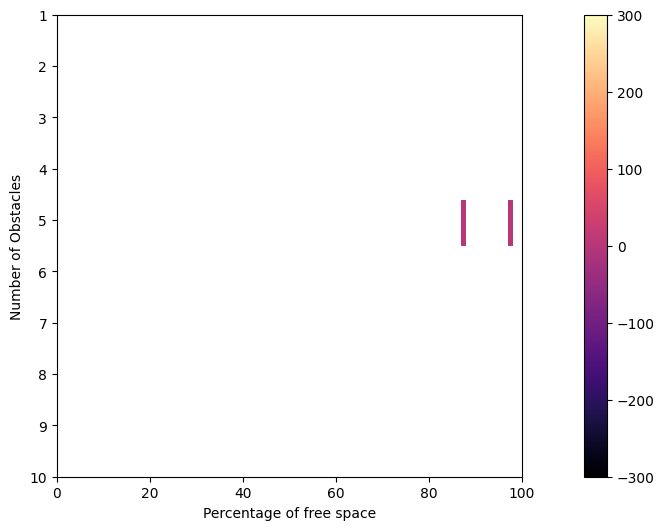

In [45]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive, vmin=-300, vmax=300)
plt.gca().invert_yaxis()
plt.ylabel("Number of Obstacles")
plt.xlabel("Percentage of free space")

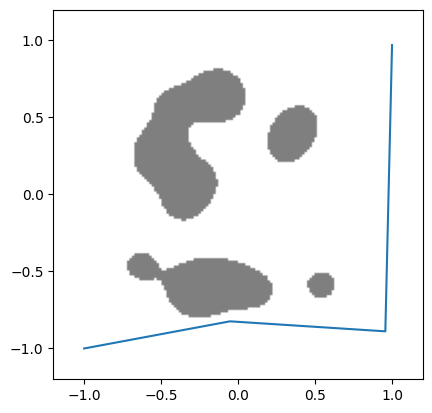

Elite(sol=array([ 8.46934595,  0.8141175 , 29.79778944]), obj=3.3717674333755285, beh=array([87.24888889,  5.        ]), idx=(87, 4), meta=None)


In [49]:
elite = archive.elite_with_behavior([87, 5])
evaluate(elite.sol, True)
print(elite)